# [Log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)
In probability theory, a log-normal (or lognormal) distribution is a continuous probability distribution of a random variable whose logarithm is normally distributed.  
  
**The PDF (Probability Density Function) of a normal distribution is**  
$ f(x) = \frac{1}{ \sigma \sqrt{2 \pi}} e^- \frac{1}{2} {(\frac{(x-\mu)}{\sigma})}^{2} $

## Import python modules

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os 
import pandas as pd
import math

## Observations: the protein coding gene length distribution for the different species

### Retrieve the statistical description of the lenght's distributions and the taxonomical id of the species

#### Statistical description 

In [20]:
# statistics on length distribution for different species     
stat_file = "../main_tables/stat_protCodGenes.tsv"
print("The statistical description of the protein coding gene distribution for the different species is in:\n", stat_file, "\n")

# retrieve data and diminish the number of columns
stat_df = pd.read_csv(stat_file, low_memory=False, sep="\t")
stat_df = stat_df[["division_7", "species", "trunk_genes_path", "genes_file", "count", "mean", "var"] + ["log10_mean", "log10_var"]]

# visualize data
pd.set_option('display.max_columns', None)
if 1:
    display(stat_df.head(2))
    print(stat_df.shape)

The statistical description of the protein coding gene distribution for the different species is in:
 ../main_tables/stat_protCodGenes.tsv 



,division_7,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var
0,vertebrates,loxodonta_africana,ftp.ensembl.org/pub/release-98/genes/loxodonta...,protein_coding.genes.loxodonta_africana.nan.en...,20033,38075.419757,5.738609e+09,4.007482,0.593872
1,vertebrates,sus_scrofa_tibetan,ftp.ensembl.org/pub/release-98/genes/sus_scrof...,protein_coding.genes.sus_scrofa_tibetan.nan.en...,19974,49828.490538,7.845625e+09,4.224371,0.495779


(33629, 9)


#### Taxonomy id for each species from Ensembl

In [21]:
# ENSEMBL tax_id     
ensembl_taxId_file = "../main_tables/extra_tables/species_Ensembl.tsv" 

# retrieve data
taxid_df = pd.read_csv(ensembl_taxId_file, sep="\t")
taxid_df = taxid_df[["#name", "species", "taxonomy_id"]]
taxid_df.rename(columns = {"#name" : 'name', "taxonomy_id" : 'tax_id'}, inplace = True)

# visualize data
pd.set_option('display.max_columns', None)
if 1:
    display(taxid_df.head(2))
    print(taxid_df.shape)

,name,species,tax_id
0,Spiny chromis,acanthochromis_polyacanthus,80966
1,Panda,ailuropoda_melanoleuca,9646


(33021, 3)


In [22]:
# Use pandas.merge() on multiple columns
stat_taxid_df = pd.merge(stat_df, taxid_df, on=['species'])
stat_taxid_df = stat_taxid_df[stat_taxid_df['tax_id'].notna()]
if 0:
    display(stat_taxid_df.head(2))
    print(stat_taxid_df.shape)

## Python functions

In [24]:
# Function to plot the log-normal distribution
# blue: Observation
# red: Theoretical/Simulation
##########################################
def plot_log_norm (log10_len, mu, sigma, N, title, subtitle, xlabel, ylabel): # N is number of 
    print("µ:", mu, "\tσ:", sigma)
    my_normal_dist = np.random.normal(mu, sigma, N)
    count, bins, *rest = plt.hist(log10_len, 60, density=True, alpha=0.8, edgecolor='black')

    # plt.hist(my_normal_dist, 30, density=True, alpha=0.25, color="r")
    # print(count); print(bins); print(*rest)
    
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
             np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
             linewidth=2, color='r', alpha=0.5)
     
    # mean
    plt.vlines(x = mu, ymin = 0, ymax = 0.2, colors = 'white', label = 'mean')
    plt.xlim([1,7]); plt.ylim([0,1.5])
    plt.suptitle(title); plt.title(subtitle + " (N=" + str(int(N)) +")")
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.show()

In [25]:
# species' stats for length distribution
def get_df_for_taxid(df, taxid):
     return df.loc[df["tax_id"]==taxid].copy()

In [26]:
def does_it_fits_normal(data_observed): 
    # Kurtosis and Skewness
    # =====================
    print('Kurtosis:', stats.kurtosis(data_observed))
    print('Skewness:', stats.skew(data_observed))
    # D'Agostino's K-squared test
    # ===========================
    k2, p_value = stats.normaltest(data_observed)
    print(f"D'Agostino's K-squared test(Estadístico={k2}, p-value={p_value})")

Deja de ser una log-normal (teóricamente)
- Kurtosis o Skewness: $\leq -1$ o $\geq 1$ 
- D'Agostino's K-squared test: p-value $ \leq 0.05 $, porque rechaza la hipótesis nula 

In [27]:
# The next function performs the whole analysis
def species_gene_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id):
    species_df = get_df_for_taxid(stat_taxid_df, tax_id)
    species_df.drop_duplicates(subset=['tax_id'], inplace=True, keep='last')
    display(species_df)
    
    genes_f = base_dir + "results/geneLength/" + species_df["trunk_genes_path"].item() + species_df["genes_file"].item()
    print(genes_f)
    # retrieve data
    genes_df = pd.read_csv(genes_f, sep="\t")
    genes_df = genes_df[["length"]]
    # visualize data
    pd.set_option('display.max_columns', None)
    if 0:
        display(genes_df.head(2))
        print(genes_df.shape)
    
    # plot the distributions: observed and theoretical
    genes_df["log10_length"] = genes_df["length"].apply(np.log10)
    title = species_df["species"].item().capitalize(); subtitle = "Observation";  xlabel = "Gene length"; ylabel = "PDF"
    plot_log_norm (genes_df["log10_length"], species_df["log10_mean"].item(), math.sqrt(species_df["log10_var"].item()), species_df["count"].item(), 
                   title, subtitle, xlabel, ylabel)  
    # fit to normal
    does_it_fits_normal(genes_df["log10_length"])

## Species:

### Homo sapiens
```{note}
tax_id = 9606
```

#### Retrieve statistical description

In [28]:
tax_id = 9696
human_df = get_df_for_taxid(stat_taxid_df, 9606)
display(human_df)

,division_7,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
90,vertebrates,homo_sapiens,ftp.ensembl.org/pub/release-98/genes/homo_sapi...,protein_coding.genes.homo_sapiens.nan.ensembl....,19976,68287.089808,1.753600e+10,4.40396,0.415191,Human,9606


#### Retrieve genes

In [32]:
# system
system = list(os.uname())[0]
if system == 'Linux':
    our_mnt_dir = "/media/emuro/Nubya/" # my disks: Wes, Nubya
elif system == 'Darwin':
    our_mnt_dir = "/Volumes/Wes/" # my disks: Wes, Nubya 
    
genes_f = our_mnt_dir + "results/geneLength/" + human_df["trunk_genes_path"].item() + human_df["genes_file"].item()
print(genes_f)
print("All the genes with their lengths of the species are in:\n", genes_f, "\n")


# retrieve data
genes_df = pd.read_csv(genes_f, sep="\t")
genes_df = genes_df[["length"]]

# visualize data
pd.set_option('display.max_columns', None)
if 0:
    display(genes_df.head(2))
    print(genes_df.shape)

/media/emuro/Nubya/results/geneLength/ftp.ensembl.org/pub/release-98/genes/homo_sapiens/protein_coding.genes.homo_sapiens.nan.ensembl.98.tsv
All the genes with their lengths of the species are in:
 /media/emuro/Nubya/results/geneLength/ftp.ensembl.org/pub/release-98/genes/homo_sapiens/protein_coding.genes.homo_sapiens.nan.ensembl.98.tsv 



#### Plot the log-normal

mu: 4.40396048586088 	sigma: 0.644352861905651


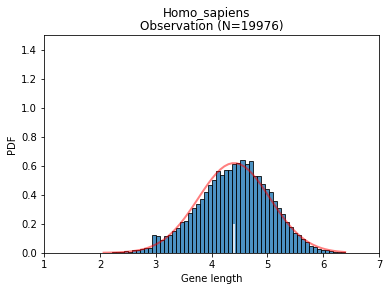

In [12]:

genes_df["log10_length"] = genes_df["length"].apply(np.log10)
title = human_df["species"].item().capitalize(); subtitle = "Observation";  xlabel = "Gene length"; ylabel = "PDF"
plot_log_norm (genes_df["log10_length"], human_df["log10_mean"].item(), math.sqrt(human_df["log10_var"].item()), human_df["count"].item(), 
               title, subtitle, xlabel, ylabel)  

#### Does the distribution fits the normal distribution?

In [13]:
does_it_fits_normal(genes_df["log10_length"]) 

Kurtosis: -0.1116735171105625
Skewness: -0.19274087219104544
D'Agostino's K-squared test(Estadístico=133.03487000453904, p-value=1.293734108353449e-29)


### Danio rerio

,division_7,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
69,vertebrates,danio_rerio,ftp.ensembl.org/pub/release-98/genes/danio_rerio/,protein_coding.genes.danio_rerio.nan.ensembl.9...,25432,31084.050802,2.666395e+09,4.137251,0.330834,Zebrafish,7955


/media/emuro/Wes/results/geneLength/ftp.ensembl.org/pub/release-98/genes/danio_rerio/protein_coding.genes.danio_rerio.nan.ensembl.98.tsv
mu: 4.1372512074567 	sigma: 0.5751817206250265


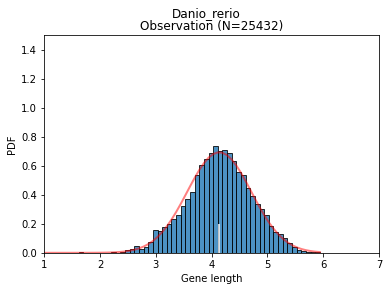

Kurtosis: 0.13464961203755843
Skewness: -0.15265070017727597
D'Agostino's K-squared test(Estadístico=114.79272415546741, p-value=1.1832504227909413e-25)


In [14]:
tax_id = 7955
species_gene_distribution__retrieve_plot_and_fit(stat_taxid_df, 7955)

### Drosophila melanogaster

,division_7,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
260,metazoa,drosophila_melanogaster,ftp.ensemblgenomes.org/pub/metazoa/release-49/...,protein_coding.genes.drosophila_melanogaster.m...,13947,6953.27203,5.892690e+08,3.430466,0.26197,Drosophila melanogaster,7227


/media/emuro/Wes/results/geneLength/ftp.ensemblgenomes.org/pub/metazoa/release-49/genes/drosophila_melanogaster/protein_coding.genes.drosophila_melanogaster.metazoa.ensemblgenomes.49.tsv
mu: 3.43046561066054 	sigma: 0.5118295836225989


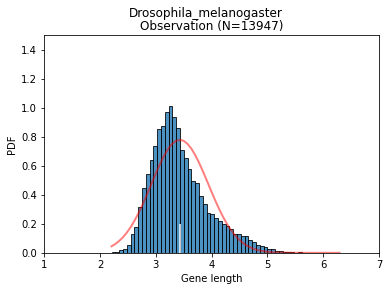

Kurtosis: 0.7006851092488566
Skewness: 0.8779483795938732
D'Agostino's K-squared test(Estadístico=1514.1399175368922, p-value=0.0)


In [15]:
tax_id = 7227
species_gene_distribution__retrieve_plot_and_fit(stat_taxid_df, 7227) # tax_id=7227

### Arabidopsis thaliana

,division_7,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
391,plants,arabidopsis_thaliana,ftp.ensemblgenomes.org/pub/plants/release-49/g...,protein_coding.genes.arabidopsis_thaliana.plan...,27628,2371.752932,2.676062e+06,3.277692,0.097997,Arabidopsis thaliana,3702


/media/emuro/Wes/results/geneLength/ftp.ensemblgenomes.org/pub/plants/release-49/genes/arabidopsis_thaliana/protein_coding.genes.arabidopsis_thaliana.plants.ensemblgenomes.49.tsv
mu: 3.27769212335358 	sigma: 0.313044095685159


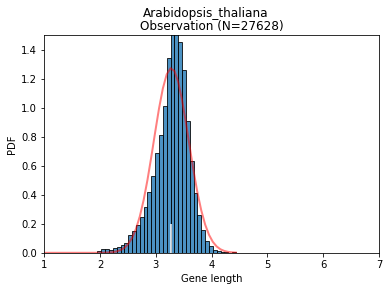

Kurtosis: 2.0687251985740804
Skewness: -0.838796770338856
D'Agostino's K-squared test(Estadístico=3819.8068409312245, p-value=0.0)


In [16]:
tax_id = 3702
species_gene_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id)

### Saccharomyces cerevisae

,division_7,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
1439,fungi,saccharomyces_cerevisiae,ftp.ensemblgenomes.org/pub/fungi/release-49/ge...,protein_coding.genes.saccharomyces_cerevisiae....,6600,1343.369091,1.260539e+06,2.992353,0.129536,Saccharomyces cerevisiae,4932


/media/emuro/Wes/results/geneLength/ftp.ensemblgenomes.org/pub/fungi/release-49/genes/saccharomyces_cerevisiae/protein_coding.genes.saccharomyces_cerevisiae.fungi.ensemblgenomes.49.tsv
mu: 2.99235333562091 	sigma: 0.3599113695628981


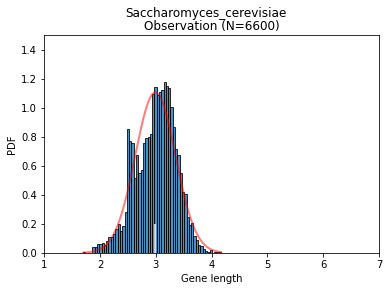

Kurtosis: -0.09977294845214058
Skewness: -0.32662637798603494
D'Agostino's K-squared test(Estadístico=114.73783365487019, p-value=1.216174768626479e-25)


In [17]:
tax_id = 4932 #uniprot: 559292 (not in ensembl) 
species_gene_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id)

### Escherichia coli

,division_7,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
21331,bacteria,escherichia_coli_o157_h7_gca_004100305,ftp.ensemblgenomes.org/pub/bacteria/release-49...,protein_coding.genes.escherichia_coli_o157_h7_...,5408,890.443972,484006.815799,2.834198,0.109331,Escherichia coli O157:H7 (GCA_004100305),83334


/media/emuro/Wes/results/geneLength/ftp.ensemblgenomes.org/pub/bacteria/release-49/genes/bacteria_22_collection/escherichia_coli_o157_h7_gca_004100305/protein_coding.genes.escherichia_coli_o157_h7_gca_004100305.bacteria.ensemblgenomes.49.tsv
mu: 2.83419833948949 	sigma: 0.33065182007980387


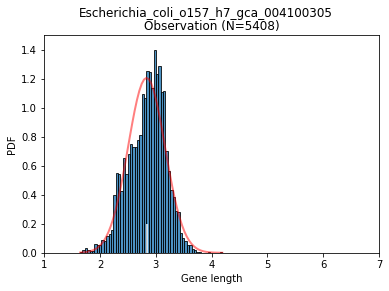

Kurtosis: -0.030039599976793063
Skewness: -0.3489768452874405
D'Agostino's K-squared test(Estadístico=104.14528610030013, p-value=2.4273838894551697e-23)


In [18]:
tax_id = 83334 #562 uniprot: 83333 (k12), 83334(0157:h7 disease), 1408285 (otra, this is not in ensembl)
species_gene_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id)